# Vegetation Index Analysis for Agricultural Parcels

*Author: Alessandro Jopshua Pierro*

*Affiliation: Agrscope*

*Date: December 2023*


## Overview

This notebook presents a detailed analysis of vegetation indices derived from Sentinel-2 satellite imagery. The indices, including NDVI, NDRE, and EVI, are crucial for monitoring the health and growth of crops over time within specific agricultural parcels.

## Objective

Our aim is to track the changes in these indices across different parcels, providing insights into crop development stages and potential stress factors affecting crop vigor.

## Methodology

The approach involves several key steps:

1. Preprocessing Sentinel-2 Scenes: This includes resampling and masking clouds, shadows, and snow using the preprocess_sentinel2_scenes function.

2. Extracting Spectral Data: The extract_s2data function pulls relevant data from Sentinel-2 imagery within specified time frames and cloud cover thresholds.

3. Processing Shapefiles: Aligning satellite data with geographical data of parcels.

4. Synthesizing Data: The process_shapefiles_and_extract_sentinel_data function compiles the data to generate time series graphs of the vegetation indices for each parcel.


## Kexy Functions

preprocess_sentinel2_scenes: Handles the preprocessing of Sentinel-2 scenes.
extract_s2_data: Extracts data from Sentinel-2 scenes based on specified parameters.
process_shapefiles_and_extract_sentinel_data: Combines shapefile data with extracted satellite data to produce temporal vegetation index graphs.

## Required Libraries and Dependencies

Below are the necessary libraries and modules required for the geospatial analysis and visualization. Ensure these are installed in your Python environment before running this notebook.

In [14]:
import geopandas as gpd
import warnings
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pathlib import Path
from datetime import datetime
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

In [15]:
# set environment variable to enable working with STAC from Planetary Computer
from eodal.config import get_settings
settings = get_settings()
settings.USE_STAC = True


def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds

def extract_s2_data(
        parcel: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 80,
        feature_cloud_cover_threshold: float = 50,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(parcel.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {},                      # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': 10}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'
    for scene_id, scene in mapper.data:

        # check if scene is blackfilled (nodata); if yes continue
        if scene.is_blackfilled:
            scenes_to_del.append(scene_id)
            mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
            continue

        # check cloud coverage (including shadows and snow) of the field parcel
        feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

        # if the scene is too cloudy, we skip it
        if feature_cloud_cover > feature_cloud_cover_threshold:
            scenes_to_del.append(scene_id)
            mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
            continue

        # calculate the NDVI, NDRE, EVI
        scene.calc_si('NDVI', inplace=True)
        scene.calc_si('NDRE', inplace=True)
        scene.calc_si('EVI', inplace=True)
        

    # delete scenes too cloudy or containing only no-data
    for scene_id in scenes_to_del:
        del mapper.data[scene_id]
    
    return mapper

# Functions

In [16]:
# Suppress warnings for a cleaner output
def suppress_warnings():
    warnings.filterwarnings('ignore')

# Set up the base directory and results directories
def setup_directories():
    base_dir = Path(os.path.dirname(os.path.realpath("__file__")))
    png_dir = base_dir / 'results' / 'parcel_graphs' / 'png'
    pdf_dir = base_dir / 'results' / 'parcel_graphs' / 'pdf'
    png_dir.mkdir(parents=True, exist_ok=True)
    pdf_dir.mkdir(parents=True, exist_ok=True)
    return base_dir, png_dir, pdf_dir

# Retrieve all subfolders within the base folder
def get_subfolders(base_folder):
    return [f.path for f in os.scandir(base_folder) if f.is_dir()]

# Find all shapefiles within a given subfolder
def find_shapefiles_in_subfolder(subfolder):
    return [f.path for f in os.scandir(subfolder) if f.name.endswith('.shp')]


# Extract satellite data for each parcel
def extract_data_for_parcels(parcels_geo_df):
    results = []
    for idx, parcel in parcels_geo_df.iterrows():
        parcel_gdf = gpd.GeoDataFrame([parcel], geometry='geometry', crs=parcels_geo_df.crs)
        results.append(extract_s2_data(parcel=parcel_gdf, time_start=datetime(2022, 1, 1), time_end=datetime(2023, 11, 21))) # change date as needed
    return results

# Plot data for each treatment over time
def plot_treatment_data(axes, treatment_data, color, treatment_name):
    for idx, ax in enumerate(axes):
        ax.plot(treatment_data['date'], treatment_data[idx], label=f'{treatment_name} - {idx}', marker='o', color=color)
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Save the plots for each subfolder
def save_plots(subfolder_name, fig, png_dir, pdf_dir):
    png_path = png_dir / f'Extraction_{subfolder_name}_graph.png'
    pdf_path = pdf_dir / f'Extraction_{subfolder_name}_graph.pdf'
    fig.savefig(png_path, format='png', bbox_inches='tight')
    fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

def interpolate_and_smooth_data(subset, index_label, window_size=7):
    """ Interpolate missing data points and apply smoothing for a smoother line. """
    subset['date'] = pd.to_datetime(subset['date'])
    subset = subset.set_index('date')

    # Resample the data to a regular interval (e.g., daily)
    subset_resampled = subset[index_label].resample('D').mean()

    # Interpolate the missing values
    subset_interpolated = subset_resampled.interpolate(method='time')

    # Apply a rolling window to smooth the data
    subset_smoothed = subset_interpolated.rolling(window=window_size, min_periods=1, center=True).mean()

    # Reset the index to get 'date' back as a column
    subset_smoothed = subset_smoothed.reset_index()
    return subset_smoothed


def compile_time_series_data(result_objects, parcel_gdf):
    all_pixel_ts_list = []
    for res_objects in result_objects:
            all_pixel_ts_subfolder = pd.DataFrame()

            for res in res_objects:
                metadata = res.metadata[['product_uri', 'sensing_date', 'scene_used']]
                res_complete = res.data.sort()
                records = []

                for sensing_date, scene in res_complete:
                    rec = scene.get_pixels(vector_features=parcel_gdf, band_selection=['NDVI', 'NDRE', 'EVI'])
                    rec['date'] = sensing_date.date()
                    records.append(rec)

                pixel_ts = pd.concat(records)
                pixel_ts = pixel_ts.sort_values(by='date')
                all_pixel_ts_subfolder = pd.concat([all_pixel_ts_subfolder, pixel_ts])

            all_pixel_ts_list.append(all_pixel_ts_subfolder)
    return all_pixel_ts_list

# Plot graphs for each index
def plot_index_graphs(axes, all_pixel_ts, color_mapping):
    for traitement, color in color_mapping.items():
        subset = all_pixel_ts[all_pixel_ts['Traitement'] == traitement].copy()
        for idx, index_label in enumerate(['NDVI', 'NDRE', 'EVI']):
            if subset.empty or index_label not in subset.columns:
                continue

            # Aggregate only the numeric data (index values) by date
            subset_aggregated = subset[[index_label, 'date']].groupby('date').mean().reset_index()

            # Interpolate and smooth the data
            smoothed_data = interpolate_and_smooth_data(subset_aggregated, index_label)

            # Plot the smoothed line
            axes[idx].plot(smoothed_data['date'], smoothed_data[index_label], label=f'{traitement} - {index_label}', linestyle='-', color=color)
            # Plot the original data points on top
            axes[idx].plot(subset['date'], subset[index_label], marker='o', linestyle='', color=color, alpha=0.5)

            axes[idx].set_xlabel('Date')
            axes[idx].set_ylabel(index_label)
            axes[idx].legend()
            axes[idx].grid(True)


# Configure plot aesthetics
def configure_plots(axes, subfolder_name):
    for ax in axes:
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0].set_title(f'NDVI Over Time - {subfolder_name}')
    axes[0].set_ylabel('NDVI Value')
    axes[1].set_title(f'NDRE Over Time - {subfolder_name}')
    axes[1].set_ylabel('NDRE Value')
    axes[2].set_title(f'EVI Over Time - {subfolder_name}')
    axes[2].set_ylabel('EVI Value')

# Main function 
def process_shapefiles_and_extract_sentinel_data(base_folder):
    suppress_warnings()
    base_dir, png_dir, pdf_dir = setup_directories()
    subfolders = get_subfolders(base_folder)
    all_results = []
    result_objects = []

    for subfolder in subfolders:
        shapefiles = find_shapefiles_in_subfolder(subfolder)
        if not shapefiles:
            print(f"No shapefile found in {subfolder}")
            continue
        
        parcels_geo_df = gpd.read_file(shapefiles[0])
        
        results = extract_data_for_parcels(parcels_geo_df)
        all_results.extend(results)

        result_objects.append(results)  

        all_pixel_ts_list = compile_time_series_data(result_objects, parcels_geo_df)  

        color_mapping = {
            '0N': '#66c2a5',
            'Nmin': '#fc8d62',
            'Standard': '#8da0cb',
            '0N_2': '#66c2a5',
            'Nmin_2': '#fc8d62',
            'Standard_2': '#8da0cb'
        }

        for subfolder, all_pixel_ts in zip(subfolders, all_pixel_ts_list):
            if all_pixel_ts.empty:
                continue
            
            fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
            plot_index_graphs(axes, all_pixel_ts, color_mapping)
            configure_plots(axes, os.path.basename(subfolder))
            plt.tight_layout()
            save_plots(os.path.basename(subfolder), fig, png_dir, pdf_dir)
            

    return all_results

## Graph Generation Execution

Run the code below to iterate over each subfolder in the specified base directory and create graphs for each set of parcel shapefiles.

2023-12-08 15:25:50,961 eodal        INFO     Starting extraction of sentinel2 scenes
2023-12-08 15:27:58,218 eodal        INFO     Finished extraction of sentinel2 scenes
2023-12-08 15:28:02,811 eodal        INFO     Starting extraction of sentinel2 scenes
2023-12-08 15:30:09,969 eodal        INFO     Finished extraction of sentinel2 scenes
2023-12-08 15:30:14,225 eodal        INFO     Starting extraction of sentinel2 scenes
2023-12-08 15:32:22,090 eodal        INFO     Finished extraction of sentinel2 scenes


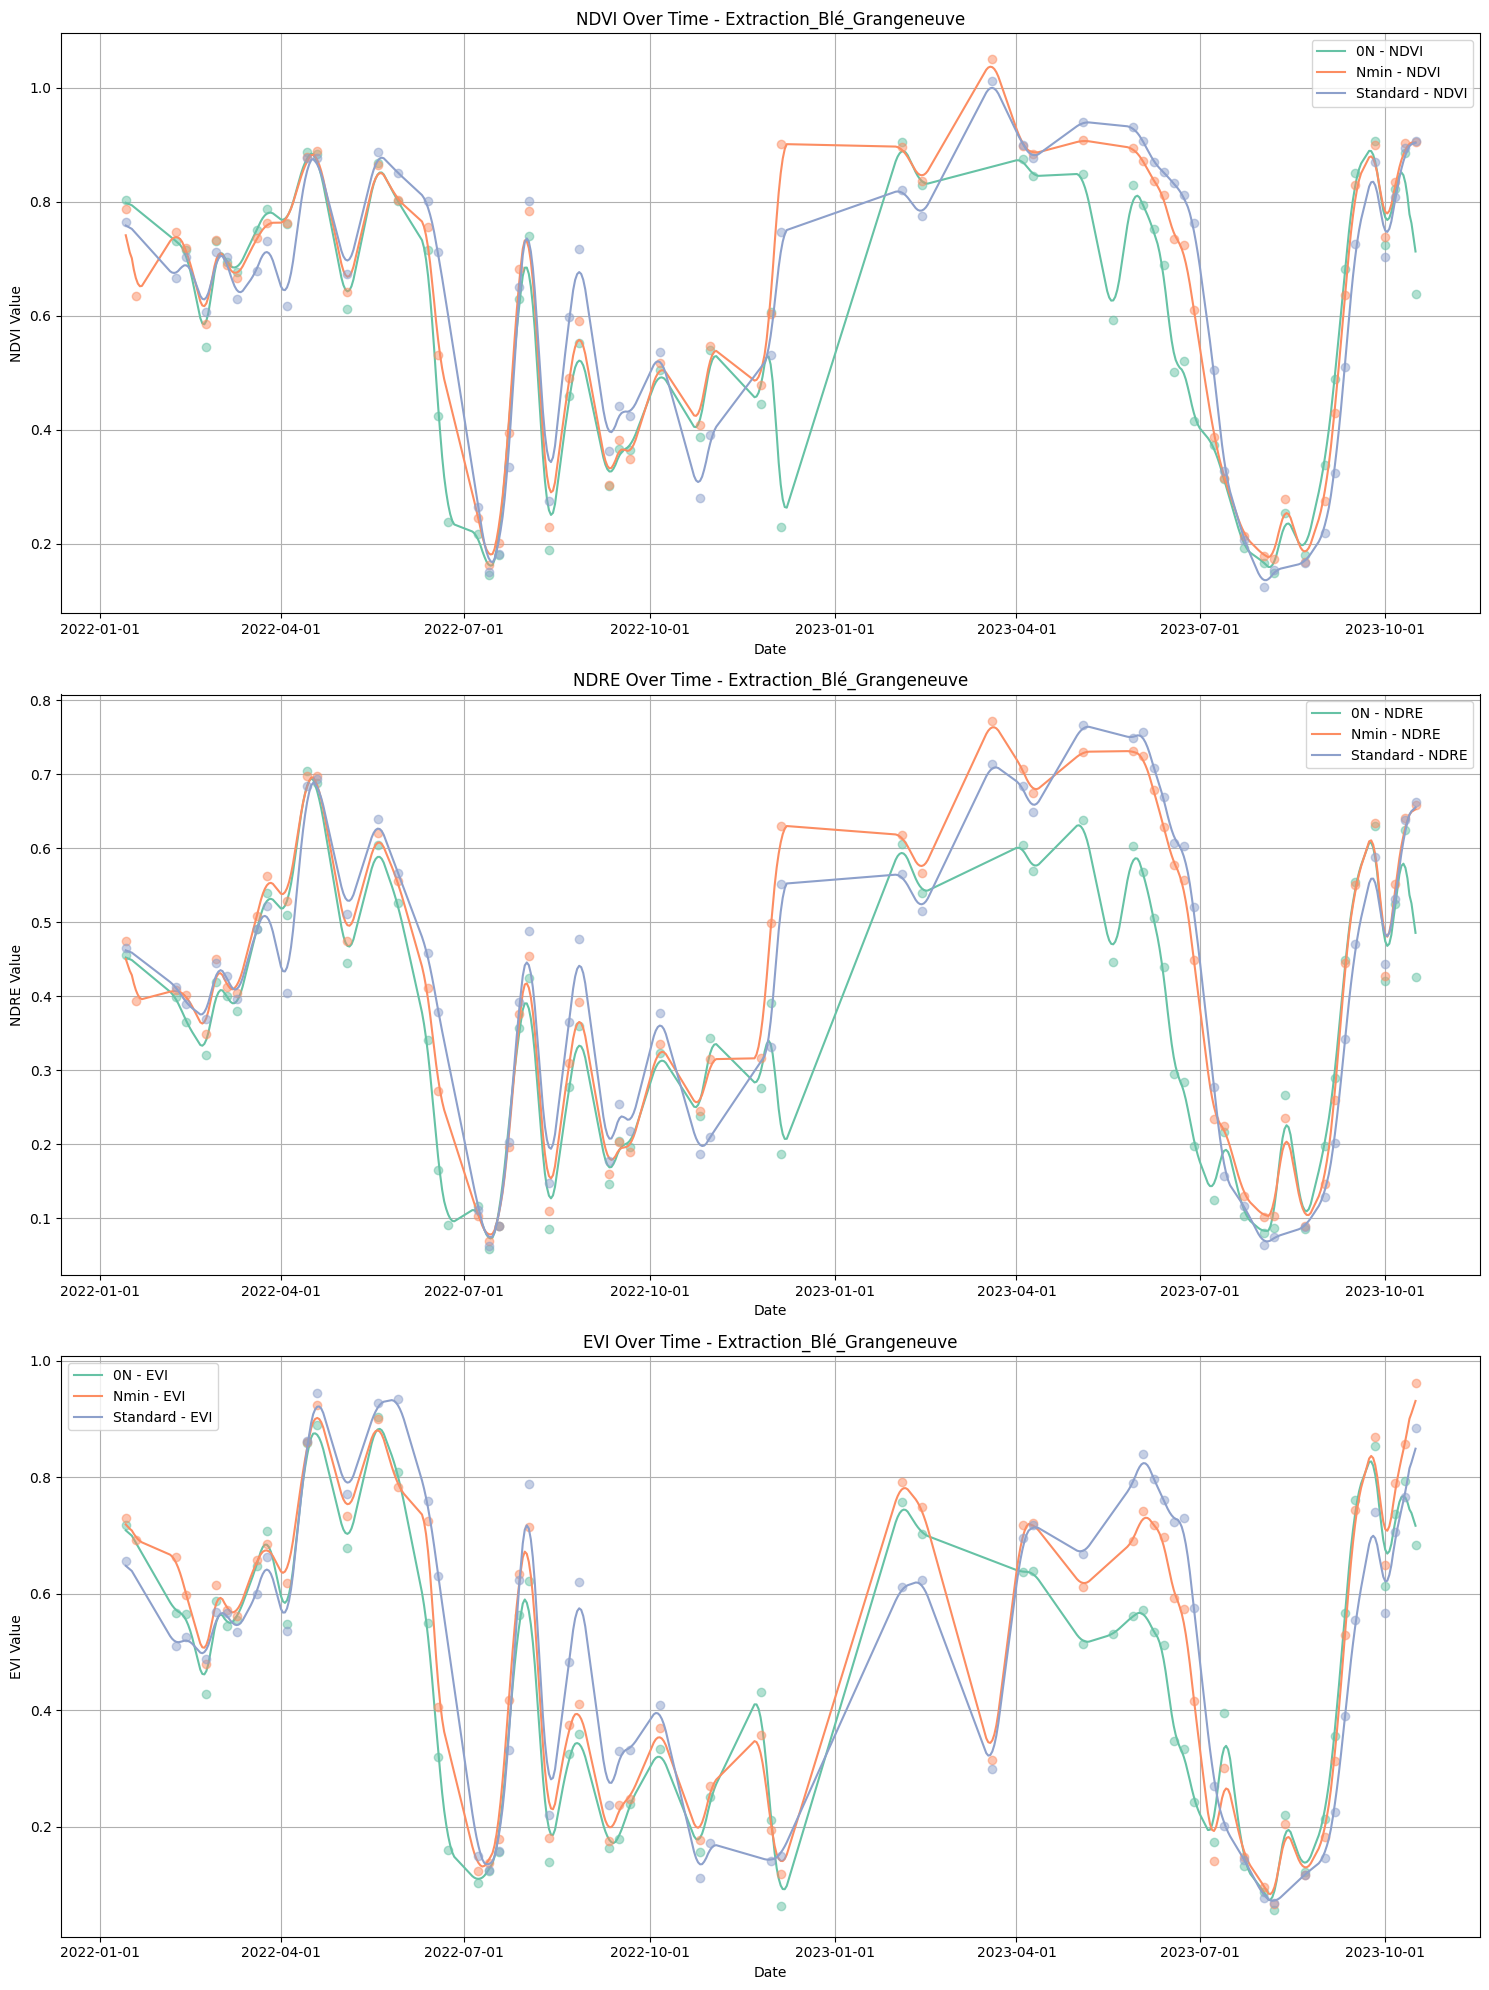

In [17]:
if __name__ == "__main__":
    base_folder_path = setup_directories()[0] / 'field_information' / 'Shapefiles'
    results = process_shapefiles_and_extract_sentinel_data(base_folder_path)